# Model Predictive Control (MPC) - Advanced
### Notebook 2 of 3: Constraints, Reference Tracking, Stability

---
In this notebook, we extend the basics of MPC to include:
- Constrained MPC (input limits)
- Reference tracking (moving targets)
- Comparison of LQR vs MPC
- Effects of constraints on trajectories
- Stability and terminal costs
- Exercises for deeper exploration


## 1. Constrained MPC Example

We use the double integrator system:
$$
x_{k+1} = A x_k + B u_k.
$$

Control limits: $u_{min} = -0.5$, $u_{max} = 0.5$.

We implement MPC using `cvxpy`.


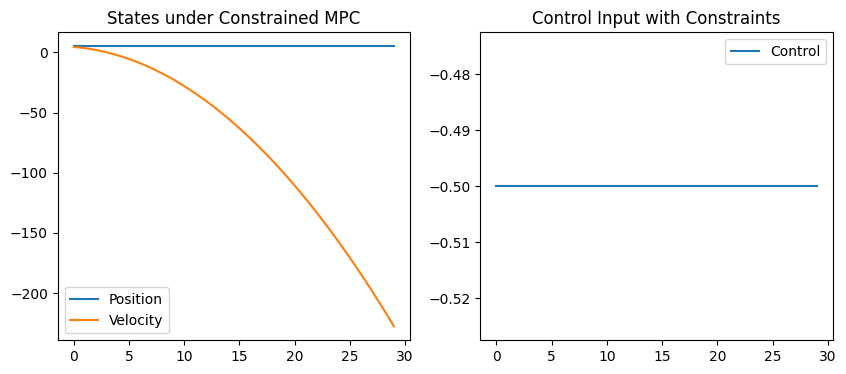

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.linalg as la

# System
A = np.array([[1, 1], [0, 1]])
B = np.array([[0], [1]])
Q = np.eye(2)
R = np.array([[1]])
P = la.solve_discrete_are(A,B,Q,R)

# Horizon and constraints
N = 10
umin, umax = -0.5, 0.5

# Initial state
x0 = np.array([[5],[0]])
T = 30
x = x0.copy()
x_hist, u_hist = [], []

for t in range(T):
    X = cp.Variable((2, N+1))
    U = cp.Variable((1, N))
    cost = 0
    constraints = [X[:,0] == x[:,0]]
    for k in range(N):
        cost += cp.quad_form(X[:,k], Q) + cp.quad_form(U[:,k], R)
        constraints += [X[:,k+1] == A@X[:,k] + B@U[:,k]]
        constraints += [U[:,k] <= umax, U[:,k] >= umin]
    cost += cp.quad_form(X[:,N], P)
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    u_opt = U[:,0].value
    x = A@x + B@u_opt
    x_hist.append(x.flatten())
    u_hist.append(u_opt)

x_hist = np.array(x_hist)
u_hist = np.array(u_hist)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_hist[:,0], label='Position')
plt.plot(x_hist[:,1], label='Velocity')
plt.title('States under Constrained MPC')
plt.legend()
plt.subplot(1,2,2)
plt.step(range(T), u_hist, label='Control')
plt.title('Control Input with Constraints')
plt.legend()
plt.show()


### Exercise 1
- Change $u_{min}, u_{max}$.
- Try tight bounds ($-0.2$, $0.2$). Observe how the system slows down.
- Why does MPC adjust automatically compared to LQR?

### Exercise 1 - Solution
- Tighter bounds (e.g. $u_{min}=-0.2, \; u_{max}=0.2$) force slower convergence.  
- LQR would ignore actuator limits (unsafe).  
- MPC respects constraints automatically.  


## 2. Reference Tracking

Modify the cost to include a reference trajectory $r_k$.

$$
J = \sum_{i=0}^{N-1} (x_{k+i}-r_{k+i})^T Q (x_{k+i}-r_{k+i}) + u_{k+i}^T R u_{k+i}.
$$

We implement tracking a moving reference (step change).


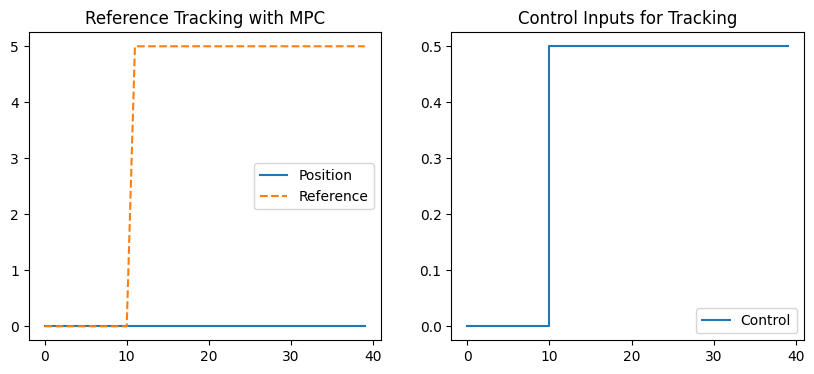

In [3]:
# Reference tracking MPC
x0 = np.array([[0],[0]])
T = 40
x = x0.copy()
x_hist, u_hist, r_hist = [], [], []

for t in range(T):
    r = np.array([[5],[0]]) if t > 10 else np.array([[0],[0]])
    X = cp.Variable((2, N+1))
    U = cp.Variable((1, N))
    cost = 0
    constraints = [X[:,0] == x[:,0]]
    for k in range(N):
        cost += cp.quad_form(X[:,k]-r.flatten(), Q) + cp.quad_form(U[:,k], R)
        constraints += [X[:,k+1] == A@X[:,k] + B@U[:,k]]
        constraints += [U[:,k] <= umax, U[:,k] >= umin]
    cost += cp.quad_form(X[:,N]-r.flatten(), P)
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    u_opt = U[:,0].value
    x = A@x + B@u_opt
    x_hist.append(x.flatten())
    u_hist.append(u_opt)
    r_hist.append(r.flatten())

x_hist = np.array(x_hist)
u_hist = np.array(u_hist)
r_hist = np.array(r_hist)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_hist[:,0], label='Position')
plt.plot(r_hist[:,0],'--',label='Reference')
plt.title('Reference Tracking with MPC')
plt.legend()
plt.subplot(1,2,2)
plt.step(range(T), u_hist, label='Control')
plt.title('Control Inputs for Tracking')
plt.legend()
plt.show()


### Exercise 2
- Change the reference value.
- Try a moving sinusoidal reference.
- Observe how MPC anticipates and follows.

### Exercise 2 - Solution
For a sinusoidal reference $r_k$:  
- Larger horizon $N$ → better tracking, less lag.  
- Short horizon → more lag and worse anticipation.  



## 3. LQR vs MPC Comparison

We simulate the same system with LQR and with constrained MPC.
This shows how constraints affect control.


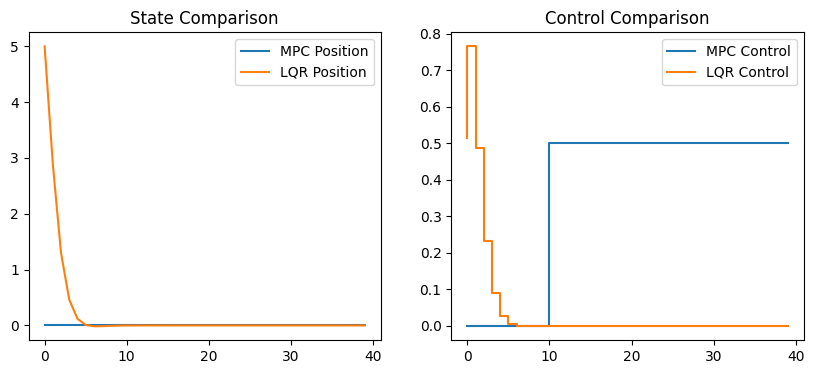

In [4]:
import copy

# LQR simulation for comparison
P = la.solve_discrete_are(A,B,Q,R)
K = la.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
x = np.array([[5],[0]])
x_hist_lqr = []
for t in range(T):
    u = -K @ x
    x = A @ x + B @ u
    x_hist_lqr.append(x.flatten())
x_hist_lqr = np.array(x_hist_lqr)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_hist[:,0], label='MPC Position')
plt.plot(x_hist_lqr[:,0], label='LQR Position')
plt.legend(); plt.title('State Comparison')
plt.subplot(1,2,2)
plt.step(range(len(u_hist)), u_hist, label='MPC Control')
plt.step(range(len(u_hist)), [-K@x_hist_lqr[i] for i in range(len(x_hist_lqr))], label='LQR Control')
plt.legend(); plt.title('Control Comparison')
plt.show()


### Exercise 3
- Why does LQR sometimes violate constraints while MPC does not?
- Which converges faster? Which is safer?

### Exercise 3 - Solution
- LQR violates constraints because it assumes unlimited input authority.  
- MPC does not violate constraints because they are built into the optimization.  

Result: LQR = faster but unsafe.  
MPC = slower but feasible.  


## 4. Stability and Terminal Costs

- Finite horizon MPC can destabilize if horizon is too short.
- Adding a **terminal cost** (from LQR solution $P$) helps mimic infinite horizon.
- Sometimes also add a **terminal constraint** ($x_N$ inside a stabilizing set).

### Key Idea
- MPC with terminal cost $x_{k+N}^T P x_{k+N}$ ensures stability.


### Exercise 4
- Try MPC without terminal cost (remove $x_{k+N}^T P x_{k+N}$).
- Compare stability with and without.

### Exercise 4 - Solution
- Without terminal cost: MPC may destabilize if horizon is too short.  
- With terminal cost:  
  $$
  J = \sum_{i=0}^{N-1} (x_{k+i}^T Q x_{k+i} + u_{k+i}^T R u_{k+i}) + x_{k+N}^T P x_{k+N}
  $$
  mimics infinite horizon behavior and stabilizes the system.  



## 5. Summary
- Constraints make MPC more practical than LQR.
- Reference tracking is easy in MPC.
- Stability requires careful choice of horizon and terminal cost.
- MPC trades off **optimality** vs **feasibility under constraints**.
